# **The fourth in-class-exercise (40 points in total, 03/29/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

In [45]:
## import libraries
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import pandas as pd
# Read data
data_tweets = pd.read_csv('/content/tweets_final.csv')  

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [46]:
# Write your code here
!pip install --upgrade gensim
import nltk;
nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
!pip install pyLDAvis
# Plotting tools


In [48]:
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [49]:
# Convert to list
data = data_tweets.tweets.values.tolist()
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
data_tweets["tweets_cleaned"] = data
# Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['rt', 'onijoseph', 'angela', 'davis', 'we', 'knew', 'the', 'role', 'of', 'the', 'police', 'was', 'to', 'protect', 'white_supremacy', 'cdnpolitics', 'cdnpoli', 'blac']


In [50]:
# Remove Stopwords, Make Bigrams and Lemmatize
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['know', 'role', 'police', 'protect']]


In [51]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
print(id2word[0])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]
know


In [52]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('know', 1), ('police', 1), ('protect', 1), ('role', 1)]]

In [53]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [54]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.393*"african" + 0.168*"country" + 0.013*"thousand" + 0.000*"leader" + '
  '0.000*"develop" + 0.000*"authority" + 0.000*"may" + 0.000*"refugee" + '
  '0.000*"support" + 0.000*"watch"'),
 (1,
  '0.150*"day" + 0.126*"allow" + 0.122*"other" + 0.028*"join" + '
  '0.011*"priority" + 0.006*"eu_countrie" + 0.001*"conversation" + '
  '0.000*"equal" + 0.000*"animal" + 0.000*"promote"'),
 (2,
  '0.608*"co" + 0.128*"gem" + 0.107*"ukrainian" + 0.042*"http" + 0.001*"wrong" '
  '+ 0.000*"cmscare" + 0.000*"apartheid" + 0.000*"abandon" + '
  '0.000*"deliberately_engage" + 0.000*"presidencyza"'),
 (3,
  '0.743*"kill" + 0.032*"young" + 0.029*"stop" + 0.028*"man" + 0.016*"tell" + '
  '0.012*"law" + 0.011*"hear" + 0.011*"ever" + 0.009*"beautiful" + '
  '0.000*"blacklivesm"'),
 (4,
  '0.090*"lead" + 0.009*"ignorance" + 0.006*"history" + 0.005*"brainwash" + '
  '0.005*"westerner" + 0.000*"proud" + 0.000*"way" + 0.000*"disappointed" + '
  '0.000*"nurse" + 0.000*"inspiration"'),
 (5,
  '0.241*"life" 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.357391 -0.368971       1        1  22.933324
10    -0.350605  0.254054       2        1  13.315468
14    -0.287915  0.245409       3        1  11.728234
2     -0.101004 -0.072021       4        1   9.880473
7     -0.001722 -0.023972       5        1   5.607631
5     -0.026408 -0.034118       6        1   5.183693
6      0.046509 -0.006868       7        1   3.714738
13     0.022709 -0.014730       8        1   3.457969
3     -0.105635 -0.075159       9        1   3.452604
11     0.087723  0.004914      10        1   2.960653
0      0.099145  0.007781      11        1   2.903631
15     0.074513  0.001395      12        1   2.902488
17     0.102174  0.008463      13        1   2.184983
16     0.051634 -0.005251      14        1   2.089619
1      0.123494  0.013258      15        1   1.919426
19     0.080939  0.003161      16        1   1.780334
4      0.151269  0.018748      17        1   1.479756
8      0.132913  0.015189      18        1   0.918483
12     0.123085  0.013182      19        1   0.906260
9      0.134575  0.015533      20        1   0.680234, topic_info=          Term         Freq        Total Category  logprob  loglift
32          co  3705.000000  3705.000000  Default  30.0000  30.0000
7        black  3695.000000  3695.000000  Default  29.0000  29.0000
270       kill  1583.000000  1583.000000  Default  28.0000  28.0000
310       even  2232.000000  2232.000000  Default  27.0000  27.0000
10      people  2374.000000  2374.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1224      safe     0.056180     2.072188  Topic20  -8.9183   1.3827
2328  security     0.056179     2.072133  Topic20  -8.9183   1.3827
403       want     0.056187     2.072860  Topic20  -8.9182   1.3825
1368   tonight     0.056179     2.072213  Topic20  -8.9183   1.3827
588       need     0.056180     2.072450  Topic20  -8.9183   1.3826

[695 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
46        5  0.910519             act
188      11  0.997132         african
180       1  0.998499  africanarchive
181       1  0.998969             ago
54       15  0.983959           allow
...     ...       ...             ...
20        6  0.522465           worry
214      14  0.985326           would
187       4  0.791665           wrong
179       1  0.998863            year
45        9  0.973548           young

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 11, 15, 3, 8, 6, 7, 14, 4, 12, 1, 16, 18, 17, 2, 20, 5, 9, 13, 10])

In [55]:
# Build LDA model with 15 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.473*"stick" + 0.141*"african" + 0.060*"country" + 0.035*"authority" + '
  '0.024*"free" + 0.016*"invade" + 0.015*"lead" + 0.007*"twitter" + '
  '0.007*"level" + 0.005*"every_single"'),
 (1,
  '0.095*"get" + 0.054*"stand" + 0.049*"harm" + 0.041*"day" + 0.036*"equal" + '
  '0.036*"put" + 0.035*"strand" + 0.035*"vote" + 0.034*"allow" + 0.034*"die"'),
 (2,
  '0.273*"black" + 0.130*"people" + 0.089*"racism" + 0.051*"ukrainian" + '
  '0.047*"surprised" + 0.046*"peopl" + 0.026*"justice" + 0.026*"abandon" + '
  '0.026*"apartheid" + 0.026*"deliberately_engage"'),
 (3,
  '0.151*"year" + 0.148*"today" + 0.138*"ago" + 0.121*"shoot" + '
  '0.116*"unarmed" + 0.089*"movement" + 0.080*"fuel" + 0.079*"africanarchive" '
  '+ 0.036*"blacklivesm" + 0.013*"power"'),
 (4,
  '0.125*"protest" + 0.086*"justiceforall" + 0.060*"leader" + 0.052*"fund" + '
  '0.040*"oldmainbell_de" + 0.028*"proud" + 0.024*"boy" + 0.019*"trucker" + '
  '0.016*"suspend" + 0.013*"lawful"'),
 (5,
  '0.116*"black" + 0.086*"fa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.281820  0.380838       1        1  16.842401
11    -0.033584  0.105968       2        1  11.871274
2     -0.239540 -0.240665       3        1  10.564663
10    -0.308094 -0.144293       4        1   9.791100
7      0.034227  0.057451       5        1   9.354372
6      0.020880  0.067389       6        1   8.686870
14    -0.070484 -0.102137       7        1   5.794485
0      0.097184  0.015434       8        1   5.235564
1      0.101359  0.015688       9        1   4.895406
5     -0.001499 -0.137914      10        1   4.691530
13     0.116932  0.006772      11        1   3.943880
12     0.116680  0.006649      12        1   3.460522
9      0.099597  0.016236      13        1   3.182873
8      0.178136 -0.025962      14        1   0.993890
4      0.170025 -0.021452      15        1   0.691170, topic_info=           Term         Freq        Total Category  logprob  loglift
270        kill  1787.000000  1787.000000  Default  30.0000  30.0000
32           co  2384.000000  2384.000000  Default  29.0000  29.0000
156       stick  1528.000000  1528.000000  Default  28.0000  28.0000
7         black  2320.000000  2320.000000  Default  27.0000  27.0000
179        year  1571.000000  1571.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1033     ignore     0.047125     1.430571  Topic15  -9.1100   1.5615
4834  irritated     0.047123     1.430532  Topic15  -9.1101   1.5615
1548   precious     0.047123     1.430558  Topic15  -9.1101   1.5615
2777      clown     0.047145     1.437877  Topic15  -9.1096   1.5568
268      ground     0.047123     1.430587  Topic15  -9.1101   1.5615

[502 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2206      3  0.993186         abandon
316       5  0.978054          action
925       7  0.831253   active_partie
188       8  0.996608         african
180       1  0.998092  africanarchive
...     ...       ...             ...
888       6  0.971478       worldwide
214       2  0.992930           would
187       3  0.725717           wrong
179       1  0.999403            year
45       11  0.989770           young

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 3, 11, 8, 7, 15, 1, 2, 6, 14, 13, 10, 9, 5])

In [56]:
# Build LDA model with 13 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.393*"african" + 0.168*"country" + 0.013*"thousand" + 0.000*"leader" + '
  '0.000*"develop" + 0.000*"authority" + 0.000*"may" + 0.000*"refugee" + '
  '0.000*"support" + 0.000*"watch"'),
 (1,
  '0.150*"day" + 0.126*"allow" + 0.122*"other" + 0.028*"join" + '
  '0.011*"priority" + 0.006*"eu_countrie" + 0.001*"conversation" + '
  '0.000*"equal" + 0.000*"animal" + 0.000*"promote"'),
 (2,
  '0.608*"co" + 0.128*"gem" + 0.107*"ukrainian" + 0.042*"http" + 0.001*"wrong" '
  '+ 0.000*"cmscare" + 0.000*"apartheid" + 0.000*"abandon" + '
  '0.000*"deliberately_engage" + 0.000*"presidencyza"'),
 (3,
  '0.743*"kill" + 0.032*"young" + 0.029*"stop" + 0.028*"man" + 0.016*"tell" + '
  '0.012*"law" + 0.011*"hear" + 0.011*"ever" + 0.009*"beautiful" + '
  '0.000*"blacklivesm"'),
 (4,
  '0.090*"lead" + 0.009*"ignorance" + 0.006*"history" + 0.005*"brainwash" + '
  '0.005*"westerner" + 0.000*"proud" + 0.000*"way" + 0.000*"disappointed" + '
  '0.000*"nurse" + 0.000*"inspiration"'),
 (5,
  '0.241*"life" 

In [57]:
# Build LDA model with 13 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.120*"african" + 0.064*"history" + 0.063*"woman" + 0.051*"country" + '
  '0.038*"donate" + 0.038*"boost" + 0.038*"rent" + 0.038*"groceries_please" + '
  '0.036*"month" + 0.023*"black"'),
 (1,
  '0.055*"white" + 0.047*"learn" + 0.035*"day" + 0.030*"strand" + 0.030*"vote" '
  '+ 0.029*"allow" + 0.028*"other" + 0.028*"state" + 0.028*"empiremike" + '
  '0.024*"interview"'),
 (2,
  '0.220*"black" + 0.107*"stick" + 0.091*"people" + 0.058*"racism" + '
  '0.055*"murder" + 0.046*"show" + 0.032*"ukrainian" + 0.029*"peopl" + '
  '0.015*"always" + 0.014*"teenager"'),
 (3,
  '0.376*"kill" + 0.030*"cmscare" + 0.028*"shouldve_turne" + '
  '0.028*"weekend_reflecte" + 0.027*"justice" + 0.025*"think" + '
  '0.019*"reality" + 0.019*"repeat" + 0.019*"audacity" + 0.016*"young"'),
 (4,
  '0.107*"may" + 0.077*"time" + 0.062*"surprised" + 0.048*"go" + 0.046*"get" + '
  '0.031*"mother" + 0.028*"theyre_convinced" + 0.026*"stand" + 0.021*"world" + '
  '0.020*"member"'),
 (5,
  '0.075*"rest" + 0.074*"lif

In [58]:
# Build LDA model with 2 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.091*"year" + 0.089*"today" + 0.083*"ago" + 0.073*"shoot" + '
  '0.070*"unarmed" + 0.053*"movement" + 0.048*"fuel" + 0.048*"africanarchive" '
  '+ 0.036*"even" + 0.035*"kill"'),
 (1,
  '0.043*"co" + 0.025*"black" + 0.014*"continue" + 0.012*"may" + 0.012*"rest" '
  '+ 0.011*"life" + 0.011*"power" + 0.011*"show" + 0.010*"say" + 0.009*"gem"')]

Perplexity:  -6.790774452433874

Coherence Score:  0.30977690505271144


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.275948  0.0       1        1  65.712044
0     -0.275948  0.0       2        1  34.287956, topic_info=               Term         Freq        Total Category  logprob  loglift
179            year  1924.000000  1924.000000  Default  30.0000  30.0000
185           today  1878.000000  1878.000000  Default  29.0000  29.0000
181             ago  1758.000000  1758.000000  Default  28.0000  28.0000
184           shoot  1538.000000  1538.000000  Default  27.0000  27.0000
186         unarmed  1477.000000  1477.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
7             black   423.195856  1445.226235   Topic2  -3.9114  -0.1578
2659  trayvonmartin    69.877500   142.475556   Topic2  -5.7125   0.3579
67             time    67.767728   229.149544   Topic2  -5.7432  -0.1479
70             make    54.708589   174.729560   Topic2  -5.9572  -0.0908
188         african    54.757289   208.497694   Topic2  -5.9563  -0.2666

[105 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2206      1  0.998328           abandon
188       1  0.738617           african
188       2  0.263792           african
180       1  0.000994    africanarchive
180       2  0.999637    africanarchive
...     ...       ...               ...
2660      1  0.016524  weekend_reflecte
2660      2  0.991425  weekend_reflecte
138       1  0.997874             woman
179       1  0.000520              year
179       2  0.999447              year

[112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [59]:
# Build LDA model with 8 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.285*"black" + 0.138*"stick" + 0.112*"people" + 0.041*"african" + '
  '0.038*"surprised" + 0.038*"peopl" + 0.022*"history" + 0.022*"woman" + '
  '0.018*"country" + 0.012*"pray"'),
 (1,
  '0.172*"even" + 0.095*"racism" + 0.089*"safety" + 0.086*"flee" + '
  '0.085*"subject" + 0.083*"reportedly" + 0.083*"attempt" + 0.083*"duri" + '
  '0.082*"people" + 0.011*"white"'),
 (2,
  '0.187*"co" + 0.059*"continue" + 0.052*"may" + 0.051*"racism" + 0.050*"rest" '
  '+ 0.039*"gem" + 0.033*"ukrainian" + 0.019*"cmscare" + 0.017*"abandon" + '
  '0.017*"apartheid"'),
 (3,
  '0.136*"year" + 0.132*"today" + 0.124*"ago" + 0.108*"shoot" + '
  '0.104*"unarmed" + 0.080*"movement" + 0.072*"fuel" + 0.071*"africanarchive" '
  '+ 0.057*"kill" + 0.032*"blacklivesm"'),
 (4,
  '0.073*"show" + 0.042*"know" + 0.038*"help" + 0.035*"get" + 0.028*"be" + '
  '0.020*"let" + 0.020*"stand" + 0.018*"harm" + 0.018*"protest" + '
  '0.016*"rent"'),
 (5,
  '0.067*"murder" + 0.059*"life" + 0.052*"say" + 0.031*"matter" + 0.

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.465657  0.017928       1        1  19.322887
2      0.047085 -0.120881       2        1  15.613530
0      0.087030 -0.113359       3        1  12.212026
6      0.074206  0.143480       4        1  11.373554
1      0.045751 -0.338602       5        1  11.317102
5      0.075878  0.120542       6        1  11.272205
7      0.060525  0.154636       7        1  10.452732
4      0.075182  0.136255       8        1   8.435965, topic_info=            Term         Freq        Total Category  logprob  loglift
7          black  2226.000000  2226.000000  Default  30.0000  30.0000
32            co  1800.000000  1800.000000  Default  29.0000  29.0000
179         year  1616.000000  1616.000000  Default  28.0000  28.0000
310         even  1202.000000  1202.000000  Default  27.0000  27.0000
185        today  1578.000000  1578.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
926      refugee    42.334735    43.311562   Topic8  -4.8113   2.4499
862         pass    41.796780    42.775496   Topic8  -4.8241   2.4495
281   dishearten    38.816375    39.793294   Topic8  -4.8981   2.4478
1052        name    37.510534    38.488463   Topic8  -4.9323   2.4469
915        train    42.657129    69.620144   Topic8  -4.8038   1.9828

[277 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2206      2  0.992582         abandon
316       3  0.989010          action
188       3  0.995475         african
180       1  0.999027  africanarchive
181       1  0.999058             ago
...     ...       ...             ...
143       2  0.987077           world
214       6  0.993018           would
179       1  0.999575            year
1303      5  0.957400             yet
45        1  0.949211           young

[247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 7, 2, 6, 8, 5])

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [58]:
# df_reviews.Review.to_csv('reviews.csv')

In [60]:
# Write your code here
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles


def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
  
def prepare_corpus(doc_clean):
  """
  Input  : clean document
  Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
  Output : term dictionary and Document Term Matrix
  """
  # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
  dictionary = corpora.Dictionary(doc_clean)
  # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
  doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
  # generate LDA model
  return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


# LSA Model
number_of_topics=7
words=10
document_list,titles=load_data("","/content/tweets_final.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 25283
[(0, '0.466*"rt" + 0.258*"year" + 0.237*"10" + 0.233*"today" + 0.229*"ago" + 0.222*"trayvon" + 0.219*"martin" + 0.217*"shot" + 0.213*"unarm" + 0.197*"georg"'), (1, '0.369*"blacklivesmatt" + 0.336*"rt" + 0.327*"http" + 0.321*"co" + 0.285*"black" + 0.247*"ukrain" + 0.181*"racism" + 0.181*"even" + 0.181*"peopl" + -0.114*"shot"'), (2, '0.487*"http" + 0.479*"co" + 0.340*"blacklivesmatt" + -0.270*"rt" + -0.234*"black" + -0.233*"even" + -0.173*"peopl" + -0.156*"ukrain" + -0.127*"safeti" + -0.125*"flee"'), (3, '0.460*"rt" + 0.347*"ding" + -0.294*"even" + 0.195*"alima1000" + -0.178*"peopl" + 0.175*"blacklivesmatt" + -0.173*"http" + -0.170*"co" + -0.163*"racism" + -0.147*"flee"'), (4, '-0.877*"ding" + 0.201*"rt" + 0.126*"alima1000" + -0.122*"even" + -0.117*"blacklivesmatt" + -0.106*"justiceforal" + -0.106*"pennstat" + 0.100*"gem" + -0.088*"amp" + 0.072*"african"'), (5, '-0.342*"gem" + 0.339*"ukrain" + 0.304*"african" + -0.267*"alima1000" + 0.217*"russia" + 0.199*

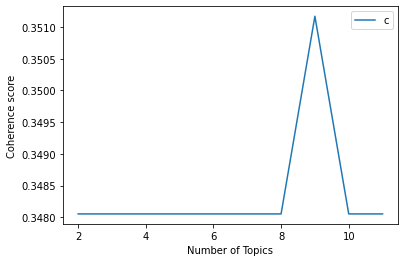

In [63]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [64]:
!pip install flask-ngrok

In [65]:
!git clone https://github.com/NikolasGialitsis/LDA2vec

fatal: destination path 'LDA2vec' already exists and is not an empty directory.


In [66]:
!pip install spacy
!pip install jellyfish
!pip install -r /content/requirements.txt
!pip install pylda2vec

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/requirements.txt'


In [67]:
 # Commented out IPython magic to ensure Python compatibility.
%cd /content/LDA2vec/
import os
import os.path
import pickle
import time
import shelve

!pip install chainer
import chainer
from chainer import cuda
from chainer import serializers
import chainer.optimizers as O
import numpy as np

from lda2vec import utils
from lda2vec import prepare_topics, print_top_words_per_topic, topic_coherence
from lda2vec import LDA2Vec
from lda2vec import preprocess, Corpus

/content/LDA2vec


In [68]:
# Write your code here
# !pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

import pyLDAvis
pyLDAvis.enable_notebook()


## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [69]:
# Write your code here
%%capture
!pip install bertopic

In [70]:
#docs = data
#docs_df = pd.DataFrame({"docs": docs})

#data_tweets["tweets_cleaned"]
#removing stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=stopwords.words('english')

# data = [re.sub('\s+', ' ', sent) for sent in data]
#docs_df['docs']=docs_df['docs'].apply(lambda x:" ".join(re.sub('\s+', ' ', sent) for sent in data))

# Remove distracting single quotes
# data = [re.sub("\'", "", sent) for sent in data]
#data_tweets['tweets_cleaned'] = data_tweets['tweets_cleaned'].apply(lambda x:" ".join(re.sub("\'", "", sent) for sent in data))
data_tweets['tweets_cleaned'] = data_tweets['tweets_cleaned'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))

#Lemmatization
from textblob import Word
nltk.download('wordnet')

data_tweets['tweets_cleaned'] = data_tweets['tweets_cleaned'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# Convert to list
docs_clean = data_tweets.tweets_cleaned.values.tolist()
docs_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['RT @OniJoseph: Angela Davis: ‘We knew role police protect white supremacy’ #BlackHistoryMonth #cdnpolitics #cdnpoli #Blac…',
 'RT @hestertainment: Breonna Taylor celebrated #Idol eve. WOW. #BlackLivesMatter #ForBreonna #SayHerName #TheNextIdol 🖤💚❤',
 'RT @AdrblyFerocious: This disturbing &amp; sickening. 🚨 Concerns mount Black people report racism fleeing #Ukraine. Scores Af…',
 'RT @joesteel80: Putin must said US invaded Mexico took territory worried Russia invading #Ukraine .#BlackL…',
 'ding... ding &amp; ding ding ding ding... Ding^ ding, ding ding! #PennState #BlackLivesMatter #JusticeForAll',
 'RT @OldMainBell: ding ding ding ding^ ding ding. DING^ DING &amp; ding #PennState #BlackLivesMatter #JusticeForAll',
 '@taylorfagins @AmericanIdol @ABCNetwork @katyperry @LionelRichie @lukebryan @RyanSeacrest OMG!! I cried felt every word song! My husband I riveted, along judges! Beautiful song! Thank you! 🖤 #BlackLivesMatter ##BlackHistoryMonth',
 'RT @CBHeresy: #BlackLivesMatter woman 

In [71]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs_clean)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2022-04-04 04:09:18,757 - BERTopic - Transformed documents to Embeddings
2022-04-04 04:10:01,307 - BERTopic - Reduced dimensionality with UMAP
2022-04-04 04:10:26,628 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [72]:
freq = topic_model.get_topic_info();
freq.head()

,Topic,Count,Name
0,-1,1590,-1_blacklivesmatter_africansinukraine_war_white
1,0,857,0_fueling_africanarchives_dead_17
2,1,380,1_even_duri_reportedly_attempt
3,2,217,2_holocaustmemorialday_mlk_grenfelltower_oprah...
4,3,203,3_mefeater_him_walking_blacklivesm


In [73]:
topic_model.get_topic(0) 

[('fueling', 0.03453372022369301),
 ('africanarchives', 0.034421638110189036),
 ('dead', 0.03326397672987371),
 ('17', 0.0330492331363934),
 ('zimmerman', 0.032986736816978716),
 ('george', 0.03176554191476088),
 ('movement', 0.030820460328800026),
 ('blac', 0.03063863380436975),
 ('unarmed', 0.028756942032384776),
 ('shot', 0.02805242627577692)]

In [74]:
topic_model.visualize_topics()

In [75]:
topic_model.visualize_barchart()

In [76]:
topic_model.visualize_heatmap()

In [77]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [78]:
topic_model.visualize_barchart()

In [79]:
topic_model.visualize_heatmap()

In [80]:
topic_model.visualize_term_rank()

In [81]:
topic_model.update_topics(docs_clean, topics, n_gram_range=(1, 2))

In [82]:
topic_model.get_topic(0)

[('fueling movement', 0.027999395462517434),
 ('fueling', 0.027999395462517434),
 ('unarmed trayvon', 0.027999395462517434),
 ('zimmerman fueling', 0.027999395462517434),
 ('africanarchives 10', 0.027939744657789665),
 ('movement blac', 0.027939744657789665),
 ('17 unarmed', 0.027939744657789665),
 ('today 17', 0.027939744657789665),
 ('rt africanarchives', 0.027939744657789665),
 ('martin shot', 0.0279093675036497)]

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

##### Write your answer here (no code needed for this question)
Latent Dirichlet allocation (LDA) is a particularly popular method for fitting a topic model. It treats each document as a mixture of topics, and each topic as a mixture of words. This allows documents to “overlap” each other in terms of content, rather than being separated into discrete groups, in a way that mirrors the typical use of natural language.

In this method, the optimal number of topics is at the highest coherence value. I have calculated the coherence score for a different number of topics like below and identified the optimal number of topics as 10. The coherence score is decreasing for a number of topics below or above 10.


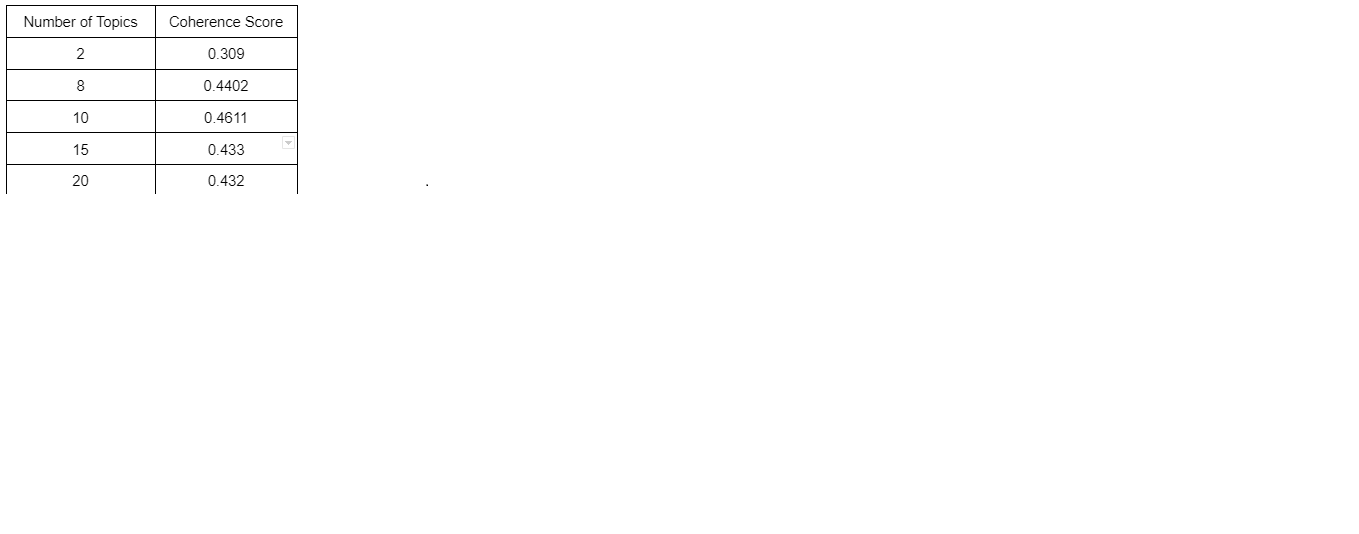

LSA, which stands for Latent Semantic Analysis, is one of the foundational techniques used in topic modeling. The core idea is to take a matrix of documents and terms and try to decompose it into separate two matrices – A document-topic matrix, A topic-term matrix. 

LSA tries to leverage the context around the words to capture the hidden or latent concepts, which are called topics.

The plot of Coherence value vs Number of topics shows that the coherence scores are maximum for number of topics 9 and the coherence value observed is 0.3510.

BerTopic:

BerTopic modeling technique uses transformers(BERT embeddings) and class-based TF-IDF to create dense clusters. It also allows you to easily interpret and visualize the topics generated.


From these results, I can say that LDA gives better results compared to LSA and BetTopic. Also, LSA offers lower accuracy than LDA.
